In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['resized-2015-2019-blindness-detection-images', 'aptos2019-blindness-detection', 'efficientnet', 'efficientnet-pytorch']


In [2]:
import sys

In [3]:
package_path = '../input/efficientnet-pytorch/efficientnet-pytorch/EfficientNet-PyTorch-master'
sys.path.append(package_path)

from efficientnet_pytorch import EfficientNet

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [6]:
from fastai import *
from fastai.vision import *
from efficientnet_pytorch import *
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 999
seed_everything(SEED)

In [8]:
print('Make sure cuda is installed:', torch.cuda.is_available())
print('Make sure cudnn is enabled:', torch.backends.cudnn.enabled)

Make sure cuda is installed: True
Make sure cudnn is enabled: True


In [9]:
from sklearn.metrics import cohen_kappa_score
def quadratic_kappa(y_hat, y):
    return torch.tensor(cohen_kappa_score(torch.round(y_hat), y, weights='quadratic'),device='cuda:0')

import cv2
def open_aptos2019_image(fn, convert_mode, after_open,tol=7)->Image:
    img = cv2.imread(fn)
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img3,img2,img1],axis=-1)
    #         print(img.shape)
        return Image(pil2tensor(img, np.float32).div_(255))
    

    

vision.data.open_image = open_aptos2019_image

from sklearn.model_selection import KFold
n_fold = 5
seed = 42
folds = KFold(n_splits=n_fold, shuffle=True, random_state=seed)        

In [10]:
import os

In [11]:
model_name = 'efficientnet-b4'
def getModel(pret,**kwargs):
    model = EfficientNet.from_name(model_name)
    model.load_state_dict(torch.load('../input/efficientnet-pytorch/efficientnet-b4-e116e8b3.pth'))
    model._fc = nn.Linear(model._fc.in_features,data.c)
    return model

In [12]:
def get_2015_df():
    base_image_dir = os.path.join('..', 'input/resized-2015-2019-blindness-detection-images/')
    train_dir = os.path.join(base_image_dir,'resized train 15/')
    df = pd.read_csv(os.path.join(base_image_dir, 'labels/trainLabels15.csv'))
    df.columns = ['image', 'diagnosis']
    #df = df[df['diagnosis'] != 0]
    df['path'] = df['image'].map(lambda x: os.path.join(train_dir,'{}.jpg'.format(x)))
    df = df.drop(columns=['image'])
    df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
    return df
df_2015 = get_2015_df()


In [13]:
def get_df_2019():
    base_image_dir = os.path.join('..', 'input/resized-2015-2019-blindness-detection-images/')
    train_dir = os.path.join(base_image_dir,'resized train 19/')
    df = pd.read_csv(os.path.join(base_image_dir, 'labels/trainLabels19.csv'))
    df['path'] = df['id_code'].map(lambda x: os.path.join(train_dir,'{}.jpg'.format(x)))
    df = df.drop(columns=['id_code'])
    df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
    test_df = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')
    return df, test_df
df_2019, test_df = get_df_2019()

In [14]:
df = pd.concat([df_2015, df_2019])

In [15]:
src = (ImageList.from_df(df=df,path='./',cols='path') #get dataset from dataset
        #.split_by_rand_pct(0.2, seed=42) #Splitting the dataset
        .split_by_idx(valid_idx=range(35126,38788))
        .label_from_df(cols='diagnosis',label_cls=FloatList) #obtain labels from the level column
      )


In [16]:
#you can play around with tfms and image sizes
bs = 64
sz = 256
#tfms = get_transforms(do_flip=True,flip_vert=True)

In [17]:
tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=360,max_zoom=1.3,max_lighting=0.1,p_lighting=0.5)
'''src = (ImageList.from_df(df=df,path='./',cols='path') #get dataset from dataset
        .split_none() #Splitting the dataset
        .label_from_df(cols='diagnosis',label_cls=FloatList) #obtain labels from the level column
      )'''
data= (src.transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') #Data augmentation
        .databunch(bs=bs,num_workers=4) #DataBunch
        .normalize(imagenet_stats) #Normalize     
       )

In [18]:
def qk(y_pred, y):
    return torch.tensor(cohen_kappa_score(torch.round(y_pred), y, weights='quadratic'), device='cuda:0')

In [19]:
learn = Learner(data,getModel(True),metrics = [rmse,qk]).to_fp16()
learn.data.add_test(ImageList.from_df(test_df,
                                      '../input/aptos2019-blindness-detection',
                                      folder='test_images',
                                      suffix='.png'))

In [20]:
learn.fit_one_cycle(5,5e-4)

epoch,train_loss,valid_loss,root_mean_squared_error,qk,time
0,0.518856,0.461226,0.673715,0.822321,29:26
1,0.435874,0.380559,0.610499,0.862790,29:28
2,0.365391,0.558120,0.742121,0.853093,30:10
3,0.314488,0.431715,0.652167,0.871742,29:50


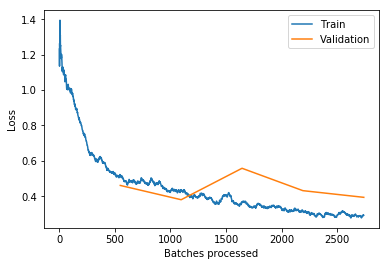

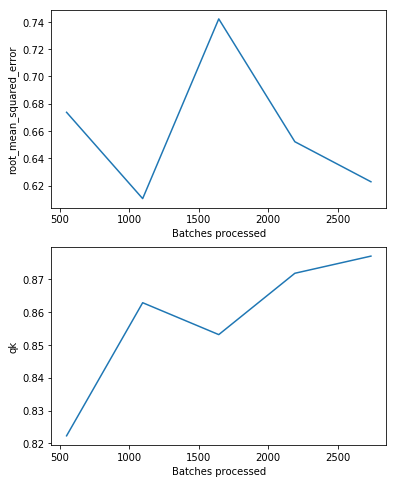

In [21]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [22]:
learn.save('model1')
learn.export('export1')

In [23]:
df=df_2019

In [24]:
src = (ImageList.from_df(df=df,path='./',cols='path') #get dataset from dataset
        .split_by_rand_pct(0.2, seed=42) #Splitting the dataset
        #.split_by_idx(valid_idx=range(35126,38788))
        .label_from_df(cols='diagnosis',label_cls=FloatList) #obtain labels from the level column
      )


In [25]:
data= (src.transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') #Data augmentation
        .databunch(bs=bs,num_workers=4) #DataBunch
        .normalize(imagenet_stats) #Normalize     
       )

In [26]:
learn = Learner(data,getModel(True),metrics = [rmse,qk]).to_fp16()
learn.data.add_test(ImageList.from_df(test_df,
                                      '../input/aptos2019-blindness-detection',
                                      folder='test_images',
                                      suffix='.png'))

In [27]:
learn.load('model1')

Learner(data=ImageDataBunch;

Train: LabelList (2930 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
2.0,0.0,0.0,3.0,0.0
Path: .;

Valid: LabelList (732 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
0.0,2.0,2.0,4.0,2.0
Path: .;

Test: LabelList (1928 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: ., model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3)

In [28]:

learn.fit_one_cycle(5,5e-4)

epoch,train_loss,valid_loss,root_mean_squared_error,qk,time
0,0.443287,0.273642,0.511786,0.911235,02:36
1,0.327819,0.207108,0.439918,0.926681,02:34
2,0.284781,0.312609,0.546938,0.913487,02:32
3,0.252758,0.208217,0.443728,0.923780,02:33
4,0.221775,0.183706,0.414506,0.932809,02:35


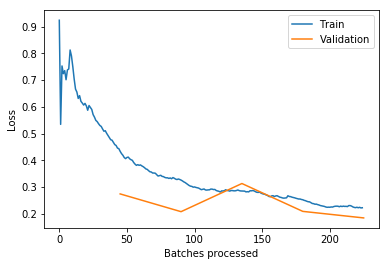

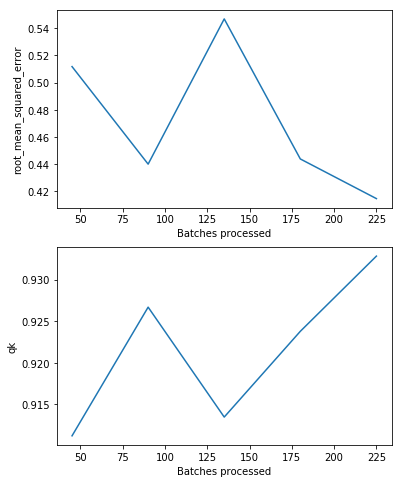

In [29]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [30]:
learn.save('model2')
learn.export('export2')

In [31]:
learn=learn.to_fp32()

In [32]:
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = metrics.cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
        print(-loss_partial(self.coef_['x']))

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [33]:
from fastai.core import *
from fastai.basic_data import *
from fastai.basic_train import *
from fastai.torch_core import *
def _tta_only(learn:Learner, ds_type:DatasetType=DatasetType.Valid, num_pred:int=20) -> Iterator[List[Tensor]]:
    "Computes the outputs for several augmented inputs for TTA"
    dl = learn.dl(ds_type)
    ds = dl.dataset
    old = ds.tfms
    aug_tfms = [o for o in learn.data.train_ds.tfms]
    try:
        pbar = master_bar(range(num_pred))
        for i in pbar:
            ds.tfms = aug_tfms
            yield get_preds(learn.model, dl, pbar=pbar)[0]
    finally: ds.tfms = old

Learner.tta_only = _tta_only

def _TTA(learn:Learner, beta:float=0, ds_type:DatasetType=DatasetType.Valid, num_pred:int=20, with_loss:bool=False) -> Tensors:
    "Applies TTA to predict on `ds_type` dataset."
    preds,y = learn.get_preds(ds_type)
    all_preds = list(learn.tta_only(ds_type=ds_type, num_pred=num_pred))
    avg_preds = torch.stack(all_preds).mean(0)
    if beta is None: return preds,avg_preds,y
    else:            
        final_preds = preds*beta + avg_preds*(1-beta)
        if with_loss: 
            with NoneReduceOnCPU(learn.loss_func) as lf: loss = lf(final_preds, y)
            return final_preds, y, loss
        return final_preds, y

Learner.TTA = _TTA

In [34]:
def run_subm(learn=learn, coefficients=[0.5, 1.5, 2.5, 3.5]):
    opt = OptimizedRounder()
    preds,y = learn.TTA(ds_type=DatasetType.Test)
    tst_pred = opt.predict(preds, coefficients)
    test_df.diagnosis = tst_pred.astype(int)
    test_df.to_csv('submission.csv',index=False)
    print ('done')

In [35]:
run_subm()

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

done
